# Different stops detection methods

In order to analyze traces collected by citizens using GNSS, one of the first need is to detect stops. 
The goal of this section is to presents methods existing in tracklib library to detect stops in a GPS track.

Ces algorithmes suivent tous le même principe de fonctionnement. Les entrées-sorties sont représentés dans la figure suivante:

<figure style='text-align:center'>
<img src="stop_structure.png"  width="650" />
<figcaption><br/>Figure 1: Input-output of stop detection algorithms</figcaption>
</figure>

Les résultats de la détection des pauses sont enregistrés dans une nouvelle trace qui contient un point par pause détectée. Ce point a une multitude d'AF qui fournit des métadonnées sur la pause comme: 

| Nom_AF           | Description                                         | 
| :--------------- | :-------------------------------------------------- | 
| radius           | le rayon spatial de recherche s'il existe           | 
| id_ini           | index du premier point de la pause                  |  
| id_end           | index du dernier point de la pause                  |  
| mean_XX          |                                                     |  
| sigma_XX         |                                                     |  
| duration         | la durée de la pause                                |  
| nb_points        | le nombre de point du stop                          |  
| rmse             | le rmse du stop                                     |  


<div class="alert alert-block alert-success">
Les 4 méthodes peuvent s'appeler avec la fonction:<br/>
<span style='padding-left:4em'>findStops(track, spatial, temporal, mode)

appelle la méthode: <br/>
    - findStopsLocal si mode == MODE_STOPS_LOCAL <br/>
    - findStopsGlobal si mode == MODE_STOPS_GLOBAL <br/>
    - findStopsLocalWithAcceleration si mode == MODE_STOPS_ACC
</div>

## Let’s start by defining our environment

The first task is only useful for the online notebook

In [1]:
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import tracklib as trk

code running in a no qgis environment
code running in a no qgis environment


## Présentation de la trace

Présentons tout d'abord la trace sur laquelle les algos de détection des points d'arrêt s'appliqueront. Voir le quickstart aussi qui utilise cette trace.

C'est une trace d'un entrainement de course à pied autour d'une piste. Grosso modo, le coureur faisait des pauses sur place d'une durée d'environ 30 secondes

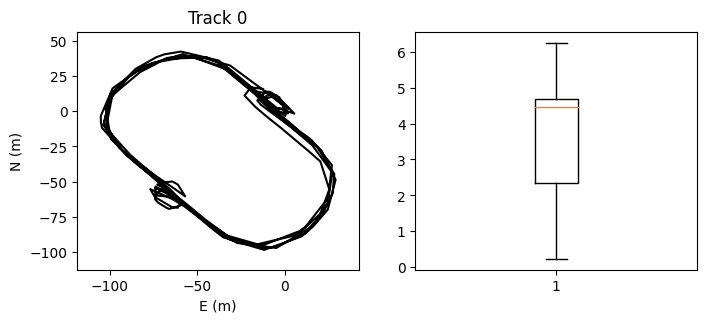

In [3]:
trk.ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")
tracks = trk.TrackReader.readFromGpx('../../../data/gpx/activity_5807084803.gpx')
trace = tracks.getTrack(0)

# Transformation GEO coordinates to ENU
trace.toENUCoords()

# speed
trace.estimate_speed()

# ---------------------------------------------------------
# Graphics
plt.figure(figsize=(8, 2))
plt.subplots_adjust(top=1.3, wspace=0.2, hspace=0.2)

ax1 = plt.subplot2grid((1, 2), (0, 0))
trace.plot(append=ax1)

ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.boxplot(trace.getAnalyticalFeature('speed'))

plt.show()

## Méthode 1: segmentation avec la vitesse maximale durant une période minimale

This algorithm take maximal speed during stop and minimal stop duration (in seconds) into account.

This algorithm of stop detection is based on geographical moving distance in time windows.


2 paramètres nécessaires: 
- duration: minimal stop duration (in seconds)
- speed: maximal speed during stop (in ground units / sec)



Number of stops:  10
['radius', 'mean_x', 'mean_y', 'mean_z', 'id_ini', 'id_end', 'sigma_x', 'sigma_y', 'sigma_z', 'duration', 'nb_points', 'rmse']


<AxesSubplot: title={'center': 'Track 0'}, xlabel='E (m)', ylabel='N (m)'>

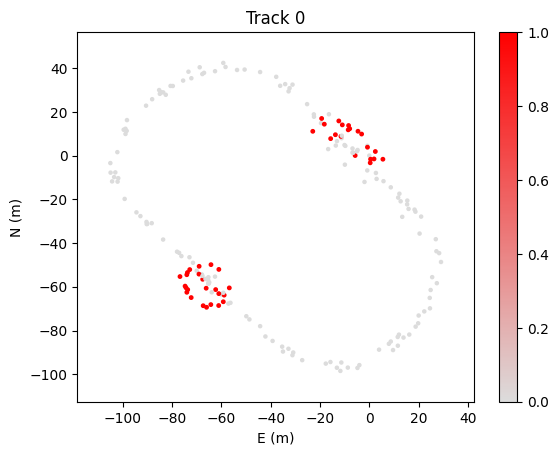

In [4]:
stops = trk.findStopsLocal(trace, speed=2, duration=15)
print ('Number of stops: ', stops.size())
print (stops.getListAnalyticalFeatures())
# print (stops['nb_points', 0], stops['duration', 0])

# --------------------------------------------------------------------------
#  On ajoute une AF pour marquer les stops
trace['stop_m1'] = 0
for i in range(stops.size()):
    id_ini = int(stops['id_ini', i])
    id_fin = int(stops['id_end', i])
    for k in range(id_ini, id_fin+1):
        trace['stop_m1', k] = 1

# On prépare la barre de couleur: gris clair: pas de pause, rouge est stop
COLS = trk.getColorMap((220, 220, 220), (255, 0, 0))

trace.plot(type='POINT', af_name='stop_m1', append = False, cmap = COLS)

## Méthode 2: take into account acceleration

Méthod: findStopsLocalWithAcceleration(track, ????)

This algorithm detect stop point, knowing that a point is a stop when speed is null or very low and acceleration is negative.

Number of stops:  2


<AxesSubplot: title={'center': 'Track 0'}, xlabel='E (m)', ylabel='N (m)'>

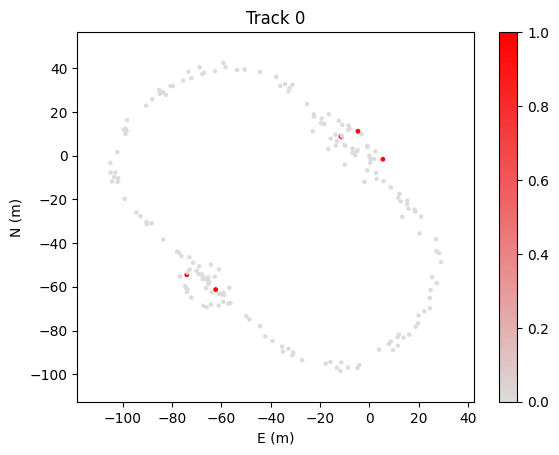

In [5]:
stops = trk.findStopsLocalWithAcceleration(trace, diameter=50, duration=15)
print ('Number of stops: ', stops.size())
# print (stops.getListAnalyticalFeatures())
# print (stops['nb_points', 0], stops['duration', 0])

# --------------------------------------------------------------------------
#  On ajoute une AF pour marquer les stops
trace['stop_m2'] = 0
for i in range(stops.size()):
    id_ini = int(stops['id_ini', i])
    id_fin = int(stops['id_end', i])
    for k in range(id_ini, id_fin+1):
        trace['stop_m2', k] = 1

# On prépare la barre de couleur: gris clair: pas de pause, rouge est stop
COLS = trk.getColorMap((220, 220, 220), (255, 0, 0))

trace.plot(type='POINT', af_name='stop_m2', append = False, cmap = COLS)

## Méthode 3: méthode des cercles englobants

Méthode: findStopsGlobal(track, diameter=20, duration=60)

This algorithm find stop points in a track based on two parameters: the maximal size of a stop (as the diameter of enclosing circle, in ground units) and minimal time duration (in seconds).

La fonction findStopsGlobal: Find stop points in a track based on two parameters:
- Maximal size of a stop (as the diameter of enclosing circle, in ground units) 
- and minimal time duration (in seconds).

100% (35 of 35) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (34 of 34) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Minimal enclosing circles computation:
Optimal split search:
9


<AxesSubplot: title={'center': 'Track 0'}, xlabel='E (m)', ylabel='N (m)'>

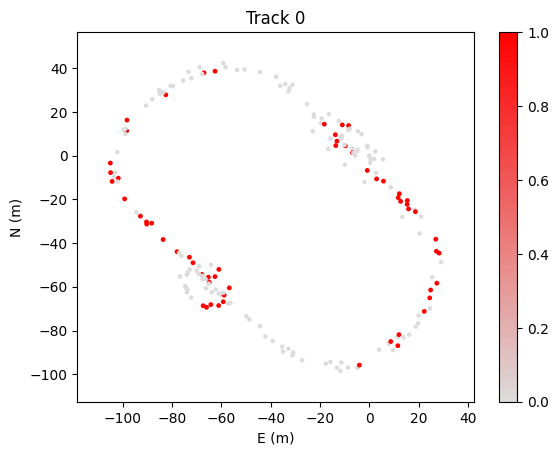

In [6]:
stops = trk.findStopsGlobal(trace, downsampling=5, diameter=30, duration=15)
print (len(stops))

# --------------------------------------------------------------------------
#  On ajoute une AF pour marquer les stops
trace['stop_m3'] = 0
for i in range(stops.size()):
    id_ini = int(stops['id_ini', i])
    id_fin = int(stops['id_end', i])
    for k in range(id_ini, id_fin+1):
        trace['stop_m3', k] = 1

# On prépare la barre de couleur: gris clair: pas de pause, rouge est stop
COLS = trk.getColorMap((220, 220, 220), (255, 0, 0))

trace.plot(type='POINT', af_name='stop_m3', append = False, cmap = COLS)

## Méthode 4: st-dbscan

<div class="alert alert-block alert-info">
<b>Reference:</b> <br/>
Birant, D., & Kut, A. (2007). ST-DBSCAN: An algorithm for clustering
spatial–temporal data. Data & Knowledge Engineering, 60(1), 208-221.
</div>

DBSCAN algorithm with three important directions:
1. First, unlike the existing density-based clustering algorithms, our algorithm can cluster spatial–temporal data according to its non-spatial, spatial and temporal attributes. 
2. Second, DBSCAN cannot detect some noise points when clusters of diﬀerent densities exist. Our algorithm solves this problem by assigning to each cluster a density factor.
3. Third, the values of border objects in a cluster may be very diﬀerent than the values of border objects in opposite side, if the non-spatial values of neighbor objects have little diﬀerences and the clusters are adjacent to each other. Our algorithm solves this problem by comparing the average value of a cluster with new coming value.


Méthode: stdbscan(track, af_name, eps1, eps2, minPts, deltaAF)

In [7]:
# Quels paramètres choisir ?
# af_name : t for timestamp
# eps1 = to measure the closeness of two points geographically
# eps2 = to measure the similarity of timestamp values i.e. the proximity timestamp
# MinPts = minimum number of points (a threshold) clustered together
# deltaAF = to prevent the discovering of combined clusters

trk.stdbscan(trace, 't', 15, 30, 5, 1)

print ('New analytical features: ', trace.getListAnalyticalFeatures())

New analytical features:  ['speed', 'stop_m1', 'acceleration', 'stop_m2', 'stop_m3', 'stdbscan', 'noise']


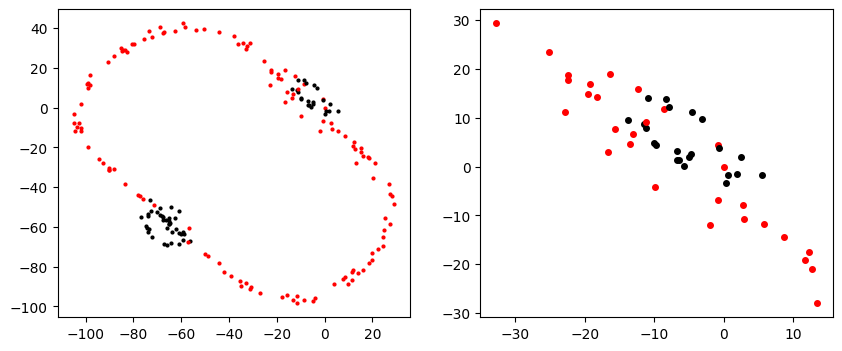

In [8]:
# visualisation des noises
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
for i in range(len(trace)):
    o = trace[i]
    if trace.getObsAnalyticalFeature('noise', i) > 0:
        ax1.plot([o.position.getX()], [o.position.getY()], 'ro', markersize=2)
    else:
        ax1.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=2)


# Dans la zone des pauses
ll = trk.ENUCoords(-40, -40)
ur = trk.ENUCoords(15, 30)
bbox = trk.Rectangle(ll, ur)
ax2 = fig.add_subplot(122)
for i in range(len(trace)):
    o = trace[i]
    if trace.getObsAnalyticalFeature('noise', i) > 0 and bbox.contains(o.position):
        ax2.plot([o.position.getX()], [o.position.getY()], 'ro', markersize=4)
    elif bbox.contains(o.position):
        ax2.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=4)
plt.show()

## Analyse des clusters pour la méthode st-dbscan

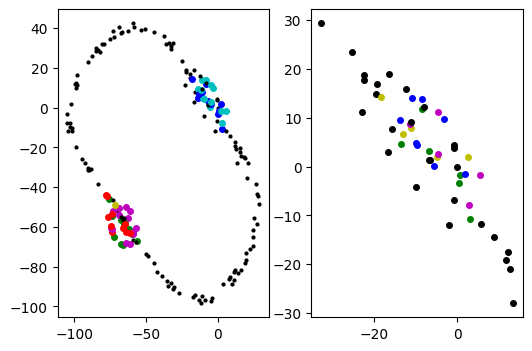

In [9]:
fig = plt.figure(figsize=(6, 4))
COLORS = ['ro','go','bo','yo','mo','co']

trace['stop_m4'] = 0

ax1 = fig.add_subplot(121)
for i in range(len(trace)):
    o = trace[i]
    cluster = trace.getObsAnalyticalFeature('stdbscan', i)
    if cluster > 0:
        #print (cluster)
        trace['stop_m4', i] = 1
        color = COLORS[cluster%6]
        ax1.plot([o.position.getX()], [o.position.getY()], color, markersize=4)
    else:
        ax1.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=2)

ax2 = fig.add_subplot(122)
cpt = 0
clusterOld = -1
d=dict()
for i in range(len(trace)):
    o = trace[i]
    cluster = trace.getObsAnalyticalFeature('stdbscan', i)
    if cluster > 0 and bbox.contains(o.position):
        if cluster != clusterOld:
            cpt += 1
            d[COLORS[cpt%6]] = []
        color = COLORS[cpt%6]
        ax2.plot([o.position.getX()], [o.position.getY()], color, markersize=4)
        d[color].append(i)
        #ax2.text(o.position.getX()+0.1, o.position.getY()+0.1, str(i))
        clusterOld = cluster
    elif bbox.contains(o.position):
        ax2.plot([o.position.getX()], [o.position.getY()], 'ko', markersize=4)
plt.show()

In [10]:
print ('Détail des clusters dans la figure de droite:')
for k in d:
    print (k, d[k])

Détail des clusters dans la figure de droite:
go [29, 30, 32, 34, 35, 36]
bo [67, 68, 69, 70, 71, 72, 73, 74]
yo [109, 110, 112, 113, 114]
mo [147, 149, 150, 151, 152]


## Graphic Abstract

Visualisation des stops points par rapport au profil de vitesse

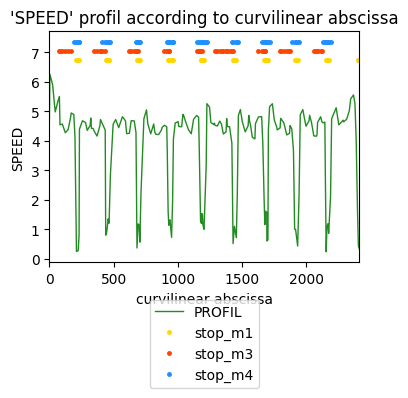

In [11]:
plt.figure(figsize=(4, 3))
plot = trk.Plot(trace)

# -----------------------------------------------------------------------------
# # On dessine

TAB_AFS = ['stop_m1', 'stop_m3', 'stop_m4']
plot.plotProfil('SPATIAL_SPEED_PROFIL', TAB_AFS, append=True)